# SNN Online Learning

In the [Key Concepts](./concepts-en.ipynb) chapter, we introduced the fundamentals of `brainscale` online learning. This section will delve into how to implement online learning for Spiking Neural Networks (SNNs) based on the `brainscale` framework.

Spiking Neural Networks provide a more biologically faithful model of neural systems, with their core mechanism being information transmission through discrete spike signals. Unlike traditional neural networks, SNNs capture information through temporal coding, emphasizing the timing and frequency of spike emissions. In online learning scenarios, SNNs can process spike events in real-time, enabling adaptation to dynamic environments and facilitating continuous learning. This learning approach not only enhances computational efficiency but also strengthens the network's temporal and spatial adaptability, effectively handling time-series data.


In [1]:
import brainstate as bst
import brainunit as u
import braintools
import brainscale

## 1. Basic Concepts of SNNs

Generally, a Spiking Neural Network comprises at least three essential components: neuronal dynamics, synaptic dynamics, and the synaptic interactions between neurons. Here, we will introduce the basic concepts of these three components through simple examples.

**LIF Neuron Model**  

The most prevalent neuronal model is the Leaky Integrate-and-fire (LIF) neuron model, which is governed by the following dynamic equations:

$$
\begin{aligned}
\tau_m \frac{dV}{dt} =& -V + V_\mathrm{rest} + R I, \\
Z =& \Theta(V - V_{\mathrm{th}}), \\
V =& V_{\mathrm{reset}} \quad \text{if} \quad Z = 1
\end{aligned}
$$

where $V$ represents the membrane potential of the neuron, $\tau_m$ is the membrane time constant, $V_{\mathrm{rest}}$ denotes the resting potential, $R$ is the membrane resistance, $I$ represents the input current, $V_{\mathrm{th}}$ is the threshold potential, $\Theta$ represents the Heaviside step function, $Z$ denotes the output spike, and $V_{\mathrm{reset}}$ is the reset potential.

The LIF neuron simulates the excitation and inhibition processes of biological neurons. When the input current $I$ is sufficiently large to cause the membrane potential $V$ to exceed the threshold potential $V_{\mathrm{th}}$, the neuron generates a spike. Following spike emission, the membrane potential is reset to $V_{\mathrm{reset}}$ and gradually returns to the resting potential $V_{\mathrm{rest}}$ over a subsequent period.

![Neuron Spiking Process](../_static/neuron-spike.gif)

Converting the above equations into discrete form yields:

$$
\begin{aligned}
V(t+1) =& V(t) + \frac{\Delta t}{\tau_m} (-V(t) + V_{\mathrm{rest}} + R I), \\
Z(t) =& \Theta(V(t) - V_{\mathrm{th}}), \\
V(t+1) =& (1 - Z(t)) * V(t+1) + Z(t) V_{\mathrm{reset}}
\end{aligned}
$$


**Synaptic Model**  

The most common synaptic model is the exponential synapse model, described by the following dynamic equation:

$$
\tau_s \frac{ds}{dt} = -s + \sum_i  W_i \delta(t - t_i),
$$

where $s$ represents the post-synaptic current, $\tau_s$ is the time constant of the post-synaptic current, and $t_i$ denotes the spike timing of presynaptic neurons.

The post-synaptic current $s$ represents the superposition of presynaptic neuronal spikes, rather than merely the count of presynaptic spikes. This post-synaptic current $s$ decays over time until the next presynaptic spike occurs.

Notably, the exponential synapse model can be effectively implemented using the AlignPost method, as discussed in [our paper](https://doi.org/10.1101/2024.09.24.614728). In the AlignPost method, the dimensionality of the post-synaptic current $s$ matches that of the neurons, with each dimension corresponding to the aggregate synaptic currents converging onto that particular neuron.

Converting the above equation into discrete form yields:

$$
\begin{aligned}
s(t+1) =& \alpha s(t) + W_1 Z_1(t) + \cdots + W_n Z_n(t) \\
I =& s(t)
\end{aligned}
$$

where $\alpha = \exp(-\Delta t / \tau_s)$ represents the decay coefficient of the post-synaptic current, $W_i$ denotes the synaptic weight in the $i$-th synaptic connection, $Z_i(t)$ represents the output spike from presynaptic neuron group $i$ at time $t$, and $I$ is the total input current received by the LIF neuron described above.

Furthermore, within the exponential-family synaptic models used for modeling synaptic dynamics, another frequently employed variant is the double exponential synapse model. This model extends the basic exponential synapse model by introducing an additional time constant to characterize both the rise and decay phases of the post-synaptic current. The distinction between exponential and double exponential synapse models is illustrated in the following figure:

![Exponential-family synapse](../_static/expo-synapse.png)

**Spiking Neural Network Model**  

Based on the aforementioned LIF neuron model and exponential synapse model, we can construct a basic spiking neural network model. In this model, we assume full connectivity between neurons, meaning each neuron is connected to all other neurons. We express the network dynamics equations in vector form as follows:

$$
\begin{aligned}
\mathbf{V}(t+1) =& \mathbf{V}(t) + \frac{\Delta t}{\tau_m} (-\mathbf{V}(t) + V_{\mathrm{rest}} + R \mathbf{I}), \\
\mathbf{Z}(t) =& \Theta(\mathbf{V}(t) - V_{\mathrm{th}}), \\
\mathbf{V}(t+1) =& (1 - \mathbf{Z}(t)) \odot \mathbf{V}(t+1) + \mathbf{Z}(t) \odot V_{\mathrm{reset}}, \\
\mathbf{s}(t+1) =& \alpha \mathbf{s}(t) + \mathbf{W}^\mathrm{in} \mathbf{Z}^\mathrm{in}(t) + \mathbf{W}^\mathrm{rec} \mathbf{Z}(t), \\
\mathbf{I} =& \mathbf{s}(t)
\end{aligned}
$$

where $\mathbf{V}$ represents the membrane potential vector, $\mathbf{I}$ denotes the input current vector, $\mathbf{Z}$ is the output spike vector, $\mathbf{s}$ represents the post-synaptic current vector, $\mathbf{W}^\mathrm{in}$ is the input synaptic weight matrix, $\mathbf{W}^\mathrm{rec}$ denotes the recurrent synaptic weight matrix within the network, and $\mathbf{Z}^\mathrm{in}$ represents the input spike vector.

**Additional References**  

The introduction provided above merely outlines the basic concepts of spiking neural networks. In reality, the dynamics of SNNs are remarkably rich and diverse. They can encompass a wide variety of neuronal dynamics, synaptic dynamics, and complex network topological structures. For more comprehensive information, please refer to [our paper](https://doi.org/10.1101/2024.09.24.614728). In practical applications, it is essential to select appropriate neuron and synapse models, design suitable network architectures, and optimize network parameters based on specific task requirements to achieve our objectives.

## 2. Online Learning for Meromorphic-MNIST Using LIF SNN

Spiking Neural Networks have been extensively employed in various **brain-inspired computing** tasks, including image classification, object detection, and speech recognition. Here, we will utilize the previously described spiking neural network model to address a Meromorphic-MNIST task.

### 2.1 N-MNIST Dataset

The [Meromorphic-MNIST dataset](https://www.garrickorchard.com/datasets/n-mnist) is derived from the classic MNIST handwritten digit dataset by converting static images into spike sequences that emulate the spiking characteristics of biological neurons. The construction of the Neuromorphic-MNIST dataset involves transforming each handwritten digit image into spike signals. This process typically encompasses the following steps: (1) Image preprocessing: The original MNIST images (28x28 pixels, grayscale) are normalized to ensure input data consistency. (2) Temporal encoding: Pixel intensities are mapped to spike sequences through various temporal encoding strategies (such as rate coding or temporal coding). For instance, pixel brightness can be represented by spike firing rates within a fixed time window. The spike sequences provided in the Neuromorphic-MNIST dataset reflect the dynamic responses of biological neurons to external stimuli, making it particularly suitable for models processing temporal data.

The N-MNIST dataset can be loaded using [tonic](https://tonic.readthedocs.io). Here is a simple example:

In [2]:
import tonic
from tonic.datasets import NMNIST
from torch.utils.data import DataLoader
import numpy as np

# Converting a dataset to a numpy array using the "numpy_collate" function
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


# dataset
in_shape = NMNIST.sensor_size
out_shape = 10
data = NMNIST(save_to='../../examples/data/', train=True, first_saccade_only=True,
              transform=tonic.transforms.ToFrame(sensor_size=in_shape, n_time_bins=200))

# Loading a dataset with PyTorch DataLoader
data = DataLoader(
    data,
    shuffle=True,
    batch_size=256,
    collate_fn=numpy_collate,
    drop_last=True,
)

### 2.2 LIF Neural Network Model

We will construct a simple three-layer spiking neural network model using the previously described LIF neuron model and exponential synapse model. This architecture consists of an input layer, a hidden layer, and an output layer. The input layer receives spike sequences from the N-MNIST dataset, the hidden layer implements the LIF neuron model, and the output layer employs a LeakyRateReadout mechanism for digit classification.

In [3]:
from typing import Callable
import matplotlib.pyplot as plt


class LIF_Delta_Net(bst.nn.Module):
    """
    LIF neurons and dense connected delta synapses.
    """

    def __init__(
        self,
        n_in, n_rec, n_out,
        tau_mem=5. * u.ms,
        tau_o=5. * u.ms,
        V_th=1. * u.mV,
        spk_fun: Callable = bst.surrogate.ReluGrad(),
        spk_reset: str = 'soft',
        rec_scale: float = 1.,
        ff_scale: float = 1.,
    ):
        super().__init__()
        self.neu = brainscale.nn.LIF(n_rec, tau=tau_mem, spk_fun=spk_fun, spk_reset=spk_reset, V_th=V_th)
        rec_init: Callable = bst.init.KaimingNormal(rec_scale, unit=u.mV)
        ff_init: Callable = bst.init.KaimingNormal(ff_scale, unit=u.mV)
        w_init = u.math.concatenate([ff_init([n_in, n_rec]), rec_init([n_rec, n_rec])], axis=0)
        self.syn = bst.nn.DeltaProj(
            comm=brainscale.nn.Linear(n_in + n_rec, n_rec, w_init=w_init, b_init=bst.init.ZeroInit(unit=u.mV)),
            post=self.neu
        )
        self.out = brainscale.nn.LeakyRateReadout(in_size=n_rec, out_size=n_out, tau=tau_o,
                                                  w_init=bst.init.KaimingNormal())

    def update(self, spk):
        self.syn(u.math.concatenate([spk, self.neu.get_spike()], axis=-1))
        return self.out(self.neu())

    def verify(self, input_spikes, num_show=5, sps_inc=10.):
        def _step(x):
            out = self.update(x)
            return out, self.neu.get_spike(), self.neu.V.value

        # input spike train
        xs = np.transpose(input_spikes.reshape(*input_spikes.shape[:2], -1), (1, 0, 2))  # [n_steps, n_samples, n_in]

        # Running the simulation model
        bst.nn.init_all_states(self, xs.shape[1])
        outs, sps, vs = bst.compile.for_loop(_step, xs)
        outs = u.math.as_numpy(outs)
        sps = u.math.as_numpy(sps)
        vs = u.math.as_numpy(vs.to_decimal(u.mV))
        vs = np.where(sps, vs + sps_inc, vs)
        max_t = xs.shape[0]

        for i in range(num_show):
            fig, gs = braintools.visualize.get_figure(4, 1, 2., 10.)

            # Input activity visualisation
            ax_inp = fig.add_subplot(gs[0, 0])
            t_indices, n_indices = np.where(xs[:, i] > 0)
            ax_inp.plot(t_indices, n_indices, '.')
            ax_inp.set_xlim(0., max_t)
            ax_inp.set_ylabel('Input Activity')

            # Visualisation of neuronal activity
            ax = fig.add_subplot(gs[1, 0])
            plt.plot(vs[:, i])
            ax.set_xlim(0., max_t)
            ax.set_ylabel('Recurrent Potential')

            # Visualisation of spiking activity
            ax_rec = fig.add_subplot(gs[2, 0])
            t_indices, n_indices = np.where(sps[:, i] > 0)
            ax_rec.plot(t_indices, n_indices, '.')
            ax_rec.set_xlim(0., max_t)
            ax_rec.set_ylabel('Recurrent Spiking')

            # Output activity visualisation
            ax_out = fig.add_subplot(gs[3, 0])
            for j in range(outs.shape[-1]):
                ax_out.plot(outs[:, i, j], label=f'Readout {j}', alpha=0.7)
            ax_out.set_ylabel('Output Activity')
            ax_out.set_xlabel('Time [ms]')
            ax_out.set_xlim(0., max_t)
            plt.legend()

        plt.show()
        plt.close()


In the code above, the `verify` function is utilized for visualizing network activity. We can examine the network's response to input spike sequences by invoking the `verify` function. Here is a simple example:

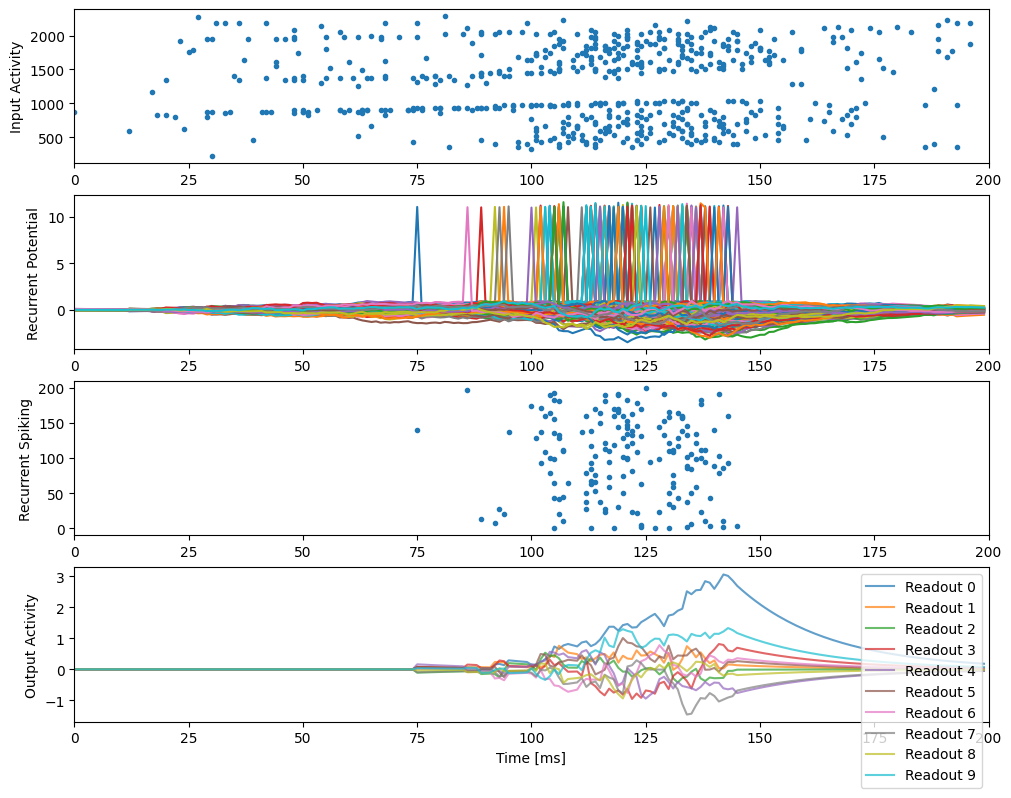

In [4]:
with bst.environ.context(dt=1. * u.ms):
    net = LIF_Delta_Net(
        n_in=int(np.prod(in_shape)),
        n_rec=200,
        n_out=out_shape,
        tau_mem=20. * u.ms,
        tau_o=20. * u.ms,
        V_th=1. * u.mV,
        rec_scale=2.,
        ff_scale=6.,
    )
    net.verify(next(iter(data))[0], num_show=1)

### 2.3 Training Framework

Next, we will implement a training framework for various spiking neural networks. The core component of this framework is the `batch_train` function, which processes one batch of data during training. We will implement two types of trainers: one based on online learning and another utilizing Backpropagation Through Time (BPTT).

In [5]:
from tqdm import tqdm
from typing import Iterable, Union
import jax

LOSS = float
ACCURACY = float


class Trainer(object):
    def __init__(
        self,
        target: bst.nn.Module,
        opt: bst.optim.Optimizer,
        dataset: Iterable,
        x_fun: Callable,
        n_sim: int = 0,
        batch_size: int = 128,
        acc_th: float = 0.90,
    ):
        super().__init__()

        # dataset
        self.dataset = dataset
        self.x_fun = x_fun

        # target network
        self.target = target

        # optimizer
        self.opt = opt
        weights = self.target.states().subset(bst.ParamState)
        opt.register_trainable_weights(weights)

        # training parameters
        self.n_sim = n_sim
        self.batch_size = batch_size
        self.acc_th = acc_th

    def _acc(self, out, target):
        return jax.numpy.mean(jax.numpy.equal(target, jax.numpy.argmax(jax.numpy.mean(out, axis=0), axis=1)))

    def batch_train(self, xs, ys) -> Union[LOSS, ACCURACY]:
        raise NotImplementedError

    def f_train(self):
        losses, accs = [], []
        n_batch = len(self.dataset)
        i_epoch = 0
        acc_ = 0.
        while acc_ < self.acc_th:
            i_epoch += 1
            bar = tqdm(enumerate(self.dataset))
            for i, (x_local, y_local) in bar:
                # training
                x_local = self.x_fun(x_local)  # [n_steps, n_samples, n_in]
                y_local = y_local  # [n_samples]
                loss, acc = self.batch_train(x_local, y_local)
                bar.set_description(f'loss = {loss:.5f}, acc={acc:.5f}', refresh=True)
                losses.append(loss)
                accs.append(acc)
            acc_ = np.mean(accs[-n_batch:])
            print(f'Epoch {i_epoch}, acc={acc_:.5f}, loss={np.mean(losses[-n_batch:]):.5f}')
        return np.asarray(losses), np.asarray(accs)


The following is an implementation of a trainer based on online learning:

In [6]:
class OnlineTrainer(Trainer):
    def __init__(self, *args, decay_or_rank=0.99, **kwargs):
        super().__init__(*args, **kwargs)
        self.decay_or_rank = decay_or_rank

    @bst.compile.jit(static_argnums=(0,))
    def batch_train(self, inputs, targets):
        # initialize the states
        bst.nn.init_all_states(self.target, inputs.shape[1])

        # weights
        weights = self.target.states().subset(bst.ParamState)

        # initialize the online learning model
        # model = brainscale.DiagParamDimAlgorithm(self.target, mode=bst.mixin.Batching())
        model = brainscale.DiagIODimAlgorithm(self.target, self.decay_or_rank)
        model.compile_graph(inputs[0])

        def _etrace_grad(inp):
            # call the model
            out = model(inp)
            # calculate the loss
            loss = braintools.metric.softmax_cross_entropy_with_integer_labels(out, targets).mean()
            return loss, out

        def _etrace_step(prev_grads, x):
            # no need to return weights and states, since they are generated then no longer needed
            f_grad = bst.augment.grad(_etrace_grad, weights, has_aux=True, return_value=True)
            cur_grads, local_loss, out = f_grad(x)
            next_grads = jax.tree.map(lambda a, b: a + b, prev_grads, cur_grads)
            return next_grads, (out, local_loss)

        def _etrace_train(inputs_):
            # forward propagation
            grads = jax.tree.map(u.math.zeros_like, weights.to_dict_values())
            grads, (outs, losses) = bst.compile.scan(_etrace_step, grads, inputs_)
            # gradient updates
            grads = bst.functional.clip_grad_norm(grads, 1.)
            self.opt.update(grads)
            # accuracy
            return losses.mean(), outs

        # running indices
        if self.n_sim > 0:
            bst.compile.for_loop(model, inputs[:self.n_sim])
        loss, outs = _etrace_train(inputs[self.n_sim:])

        # returns
        return loss, self._acc(outs, targets)


The following is the implementation of the BPTT-based trainer:

In [7]:
class BPTTTrainer(Trainer):
    @bst.compile.jit(static_argnums=(0,))
    def batch_train(self, inputs, targets):
        # initialize the states
        bst.nn.init_all_states(self.target, inputs.shape[1])

        # the model for a single step
        def _run_step_train(inp):
            out = self.target(inp)
            loss = braintools.metric.softmax_cross_entropy_with_integer_labels(out, targets).mean()
            return out, loss

        def _bptt_grad_step():
            if self.n_sim > 0:
                _ = bst.compile.for_loop(self.target, inputs[:self.n_sim])
            outs, losses = bst.compile.for_loop(_run_step_train, inputs[self.n_sim:])
            return losses.mean(), outs

        # gradients
        weights = self.target.states().subset(bst.ParamState)
        grads, loss, outs = bst.augment.grad(_bptt_grad_step, weights, has_aux=True, return_value=True)()

        # optimization
        grads = bst.functional.clip_grad_norm(grads, 1.)
        self.opt.update(grads)

        return loss, self._acc(outs, targets)

### 2.4 Online Learning vs. BPTT Offline Learning

We will now compare the performance between online learning and BPTT offline learning approaches. The online learning method utilizes the `DiagIODimAlgorithm` from `brainscale`, which is an $O(N)$ complexity online learning algorithm specifically designed for spiking neural networks. BPTT employs the backpropagation algorithm, which is an offline learning method based on classical surrogate gradient functions. BPTT has proven effective in training deep spiking neural networks.

In [8]:
# Training using online learning

with bst.environ.context(dt=1. * u.ms):
    onliner = OnlineTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        x_fun=lambda x: np.transpose(x.reshape(*x.shape[:2], -1), (1, 0, 2)),
        acc_th=0.90,
    )

    losses, accs = onliner.f_train()

loss = 0.72046, acc=0.91797: : 234it [04:38,  1.19s/it]


Epoch 1, acc=0.86809, loss=0.98207


loss = 0.60397, acc=0.94922: : 234it [04:01,  1.03s/it]

Epoch 2, acc=0.94266, loss=0.59986


Here are the training results from the online learning:

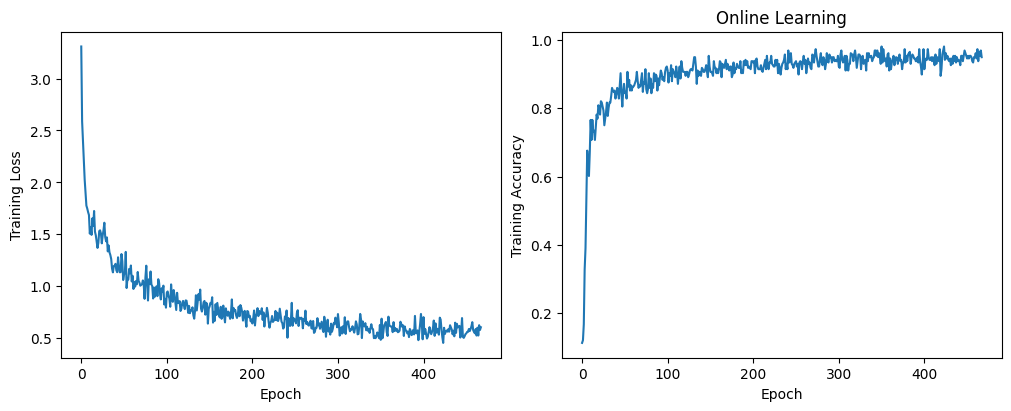

In [9]:
fig, gs = braintools.visualize.get_figure(1, 2, 4., 5.)
fig.add_subplot(gs[0, 0])
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
fig.add_subplot(gs[0, 1])
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Online Learning')
plt.show()

We can visualise the network activity of a sample:

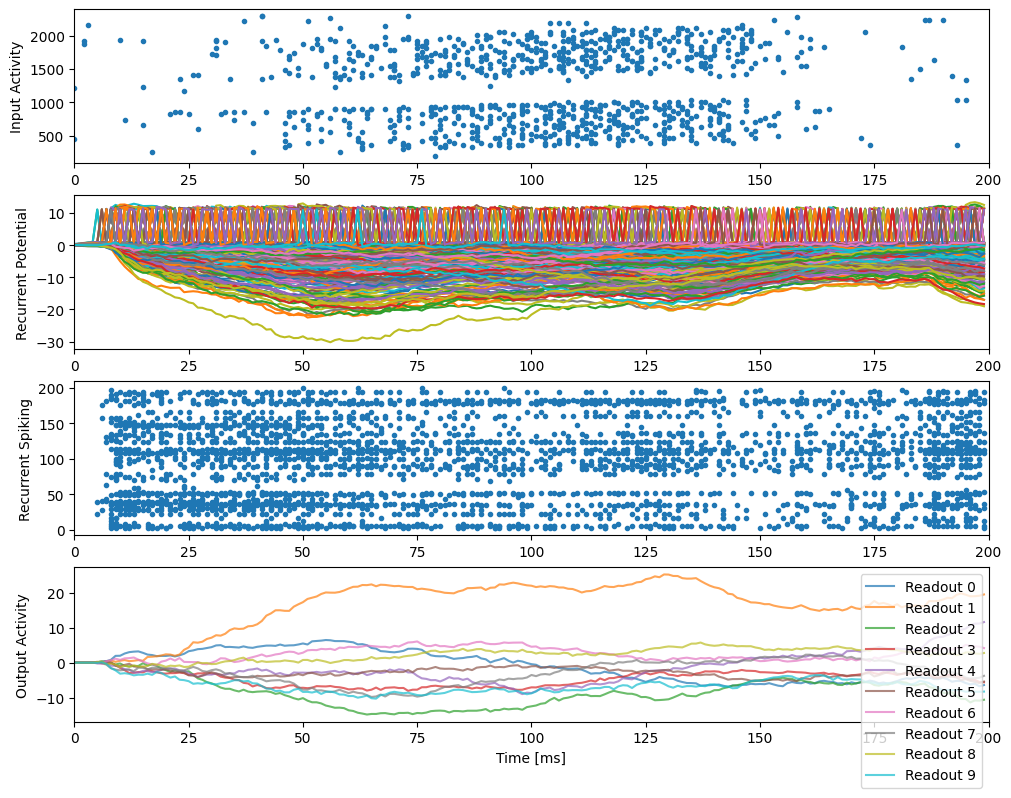

In [10]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

In the following we use BPTT offline learning for training:

In [11]:
with bst.environ.context(dt=1. * u.ms):
    net = LIF_Delta_Net(
        n_in=int(np.prod(in_shape)),
        n_rec=200,
        n_out=out_shape,
        tau_mem=20. * u.ms,
        tau_o=20. * u.ms,
        V_th=1. * u.mV,
        rec_scale=2.,
        ff_scale=6.,
    )

    offliner = BPTTTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        x_fun=lambda x: np.transpose(x.reshape(*x.shape[:2], -1), (1, 0, 2)),
        acc_th=0.90,
    )

    losses, accs = offliner.f_train()

loss = 0.48675, acc=0.95312: : 234it [06:13,  1.60s/it]

Epoch 1, acc=0.91520, loss=0.67719


The following are the training results of BPTT offline learning:

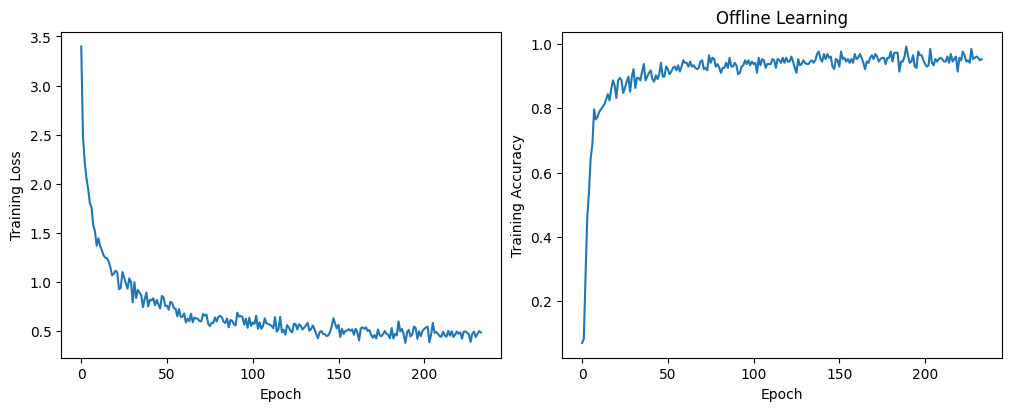

In [12]:
fig, gs = braintools.visualize.get_figure(1, 2, 4., 5.)
fig.add_subplot(gs[0, 0])
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
fig.add_subplot(gs[0, 1])
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Offline Learning')
plt.show()

We can visualise the network activity of a sample:

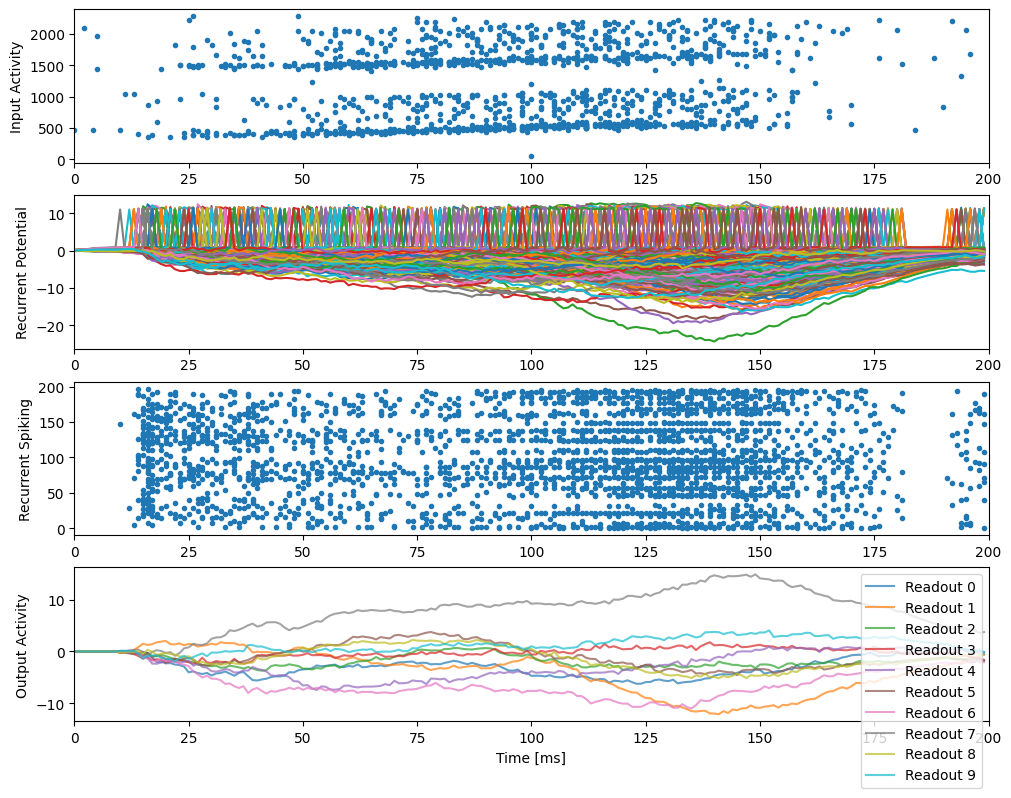

In [13]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

## 3. Online Learning for DMS Tasks Using GIF SNN

Spiking neural networks are also extensively employed in various **brain simulation** tasks to investigate neural mechanisms underlying working memory, learning, and decision-making processes.

Here, we will utilize the previously described spiking neural network model to address a challenging Delayed Matching-to-Sample (DMS) task. The DMS task is a classical working memory paradigm used to study working memory capabilities in animals. In this task, subjects must retain a sample stimulus during a delay period and subsequently select the matching option from multiple alternatives after the delay interval. This paradigm serves as a valuable tool for investigating working memory capacity and its underlying neural mechanisms.

Our neural network architecture consists of a three-layer spiking neural network, comprising an input layer, a hidden layer, and an output layer. The hidden layer implements the Generalized Integrate-and-Fire (GIF) neuron model, which incorporates adaptive current mechanisms. We will employ this spiking neural network model with online learning to solve the Delayed Matching-to-Sample task.

### 3.1 Generalized Integrate-and-Fire Neural Network

Let us now implement a Generalized Integrate-and-Fire (GIF) neuron model and construct a simple spiking neural network using the exponential synapse model.

The Generalized Integrate-and-Fire (GIF) model extends the classical integrate-and-fire model to more accurately capture the dynamics of biological neurons. Compared to simple integrate-and-fire models, the GIF model incorporates dynamic threshold mechanisms, adaptive currents, after-hyperpolarization effects, and nonlinear membrane responses, thereby better simulating neuronal dynamic behaviors. The core equations of the GIF model are:

$$
\begin{aligned}
      &\frac{d I_j}{d t} = - k_j I_j \\
      &\tau \frac{d V}{d t} = - (V - V_\mathrm{rest}) + R\sum_{j}I_j + RI  \\
      &\frac{d V_{th}}{d t} = a(V - V_\mathrm{rest}) - b(V_{th} - V_{th\infty})
\end{aligned}
$$

When $V>V_{th}$, the generalized LIF neuron triggers:

$$
\begin{aligned}
&I_j \leftarrow R_j I_j + A_j \\
&V \leftarrow V_\mathrm{reset} \\
&V_{th} \leftarrow max(V_{th,\mathrm{reset}}, V_\mathrm{th})
\end{aligned}
$$

where $V$ represents the membrane potential, $V_{rest}$ is the resting potential, $R$ denotes the membrane resistance, $I$ is the input current, $V_{th}$ represents the threshold potential, $V_{th\infty}$ is the resting threshold potential, $a$ and $b$ are threshold dynamics parameters, $I_j$ represents adaptive currents indicating arbitrary internal currents, $R_j$ is the decay coefficient of adaptive currents, $A_j$ is the increment of adaptive currents, $V_\mathrm{reset}$ is the reset potential, and $V_{th, \mathrm{reset}}$ is the threshold reset potential.

The GIF model can simulate various types of neuronal behaviors through multiple parameters and mechanisms, including:
- **Adaptation**: Simulates neuronal firing patterns under repeated stimulation through adaptive currents
- **Post-spike Inhibition**: Models temporary recovery periods after firing through inhibitory mechanisms
- **Multiple Firing Modes**: Reproduces various biological neuronal firing characteristics through parameter adjustment, such as rapid firing, adaptive firing, and burst firing

Here, we implement a simplified GIF neuron model that incorporates only the adaptive current mechanism, excluding post-spike inhibition and multiple firing modes. The dynamics equations are:

$$
\begin{aligned}
&\tau_{\mathbf{a}}\frac{\mathrm{d}\mathbf{a}}{\mathrm{d}t}=-\mathbf{a},\\&\tau\frac{d\mathbf{v}}{dt}=-\mathbf{v}+V_{\mathrm{rest}}+\mathbf{a}+\mathbf{I},\end{aligned}
$$

where $\mathbf{a}$ represents the internal adaptive current, and $\tau_\mathbf{a}$ is the time constant of the adaptive current. When $v_i$ of the $i$-th neuron satisfies $V_\mathrm{th}$, the model triggers:

$$
\mathbf{a}_{i}\leftarrow\mathbf{a}_{i}+A,\\
\mathbf{v}_{i}\leftarrow V_{\mathrm{reset}},
$$

Converting these equations into discrete form yields:

$$
\begin{aligned}&\bar{\mathbf{v}}^{t-1}=\mathbf{v}^{t-1}+\mathbf{z}^{t-1}(V_{\mathrm{reset}}-\mathbf{v}^{t-1}),\\&\mathbf{a}^{t}=e^{-\Delta t/\tau_{\mathbf{a}}}\mathbf{a}^{t-1}+\mathbf{z}^{t-1}A,\\&\mathbf{v}^{t}=e^{-\Delta t/\tau}\bar{\mathbf{v}}^{t-1}+(1-e^{-\Delta t/\tau})(V_{\mathrm{rest}}+\mathbf{I}^{t}+\mathbf{a}^{t}).\end{aligned}
$$

Here is the implementation of this GIF neuron model:

In [14]:
from typing import Callable


class GIF(bst.nn.Neuron):
    def __init__(
        self, size,
        V_rest=0. * u.mV,
        V_th_inf=1. * u.mV,
        R=1. * u.ohm,
        tau=20. * u.ms,
        tau_I2=50. * u.ms,
        A2=0. * u.mA,
        V_initializer: Callable = bst.init.ZeroInit(unit=u.mV),
        I2_initializer: Callable = bst.init.ZeroInit(unit=u.mA),
        spike_fun: Callable = bst.surrogate.ReluGrad(),
        spk_reset: str = 'soft',
        name: str = None,
    ):
        super().__init__(size, name=name, spk_fun=spike_fun, spk_reset=spk_reset)

        # parameters
        self.V_rest = bst.init.param(V_rest, self.varshape, allow_none=False)
        self.V_th_inf = bst.init.param(V_th_inf, self.varshape, allow_none=False)
        self.R = bst.init.param(R, self.varshape, allow_none=False)
        self.tau = bst.init.param(tau, self.varshape, allow_none=False)
        self.tau_I2 = bst.init.param(tau_I2, self.varshape, allow_none=False)
        self.A2 = bst.init.param(A2, self.varshape, allow_none=False)

        # initializers
        self._V_initializer = V_initializer
        self._I2_initializer = I2_initializer

    def init_state(self, batch_size=None):
        # Using the model for online learning requires initialising the state variables
        self.V = brainscale.ETraceState(bst.init.param(self._V_initializer, self.varshape, batch_size))
        self.I2 = brainscale.ETraceState(bst.init.param(self._I2_initializer, self.varshape, batch_size))

    def update(self, x=0.):
        # If a spike was issued at the previous moment, the membrane potential and the adaptive current are reset
        last_spk = self.get_spike()
        last_spk = jax.lax.stop_gradient(last_spk)
        last_V = self.V.value - self.V_th_inf * last_spk
        last_I2 = self.I2.value - self.A2 * last_spk
        # update hidden states
        I2 = bst.nn.exp_euler_step(lambda i2: - i2 / self.tau_I2, last_I2)
        V = bst.nn.exp_euler_step(lambda v, Iext: (- v + self.V_rest + self.R * Iext) / self.tau,
                                  last_V, x + I2)
        self.I2.value = I2
        self.V.value = V
        # output
        inp = self.V.value - self.V_th_inf
        inp = jax.nn.standardize(u.get_magnitude(inp))
        return inp

    def get_spike(self, V=None):
        V = self.V.value if V is None else V
        spk = self.spk_fun((V - self.V_th_inf) / self.V_th_inf)
        return spk

In the code above, we employ the exponential Euler method to update the neuronal states, including membrane potential and adaptive currents. At each time step, we compute the changes in membrane potential and adaptive currents, and determine spike generation based on whether the membrane potential exceeds the threshold potential. When a spike occurs, both the membrane potential and adaptive currents are reset accordingly.

Next, we will construct a three-layer spiking neural network model using this GIF neuron model combined with the exponential synapse model, comprising an input layer, a hidden layer, and an output layer.

In [15]:
class GifNet(bst.nn.Module):
    def __init__(
        self,
        n_in: int,
        n_rec: int,
        n_out: int,
        ff_scale: float = 1.,
        rec_scale: float = 1.,
        tau_neu: float = 5. * u.ms,
        tau_syn: float = 5. * u.ms,
        tau_I2: float = 5. * u.ms,
        A2=-1. * u.mA,
        tau_o: float = 5. * u.ms,
    ):
        super().__init__()

        # weight initialization
        ff_init = bst.init.KaimingNormal(ff_scale, unit=u.mA)
        rec_init = bst.init.KaimingNormal(rec_scale, unit=u.mA)
        w = u.math.concatenate([ff_init((n_in, n_rec)), rec_init((n_rec, n_rec))], axis=0)

        # parameters
        self.n_in = n_in
        self.n_rec = n_rec
        self.n_out = n_out

        # model layers
        self.ir2r = brainscale.nn.Linear(n_in + n_rec, n_rec, w_init=w, b_init=bst.init.ZeroInit(unit=u.mA))
        self.exp = brainscale.nn.Expon(n_rec, tau=tau_syn, g_initializer=bst.init.ZeroInit(unit=u.mA))
        self.r = GIF(
            n_rec,
            V_rest=0. * u.mV,
            V_th_inf=1. * u.mV,
            A2=A2,
            tau=tau_neu,
            tau_I2=bst.random.uniform(100. * u.ms, tau_I2 * 1.5, n_rec),
        )
        self.out = brainscale.nn.LeakyRateReadout(n_rec, n_out, tau=tau_o, w_init=bst.init.KaimingNormal())

    def update(self, spikes):
        cond = self.ir2r(u.math.concatenate([spikes, self.r.get_spike()], axis=-1))
        out = self.r(self.exp(cond))
        return self.out(out)

    def verify(self, input_spikes, num_show=5, sps_inc=10.):
        def _step(x):
            out = self.update(x)
            return out, self.r.get_spike(), self.r.V.value

        # input spike train
        xs = np.transpose(input_spikes, (1, 0, 2))  # [n_steps, n_samples, n_in]

        # simulating the model
        bst.nn.init_all_states(self, xs.shape[1])
        outs, sps, vs = bst.compile.for_loop(_step, xs)
        outs = u.math.as_numpy(outs)
        sps = u.math.as_numpy(sps)
        vs = u.math.as_numpy(vs.to_decimal(u.mV))
        vs = np.where(sps, vs + sps_inc, vs)
        max_t = xs.shape[0]

        for i in range(num_show):
            fig, gs = braintools.visualize.get_figure(4, 1, 2., 10.)

            # visualization of the input spiking activity
            ax_inp = fig.add_subplot(gs[0, 0])
            t_indices, n_indices = np.where(xs[:, i] > 0)
            ax_inp.plot(t_indices, n_indices, '.')
            ax_inp.set_xlim(0., max_t)
            ax_inp.set_ylabel('Input Activity')

            # visualization of neuronal activity
            ax = fig.add_subplot(gs[1, 0])
            plt.plot(vs[:, i])
            ax.set_xlim(0., max_t)
            ax.set_ylabel('Recurrent Potential')

            # visualization of spiking activity
            ax_rec = fig.add_subplot(gs[2, 0])
            t_indices, n_indices = np.where(sps[:, i] > 0)
            ax_rec.plot(t_indices, n_indices, '.')
            ax_rec.set_xlim(0., max_t)
            ax_rec.set_ylabel('Recurrent Spiking')

            # visualization of output activity
            ax_out = fig.add_subplot(gs[3, 0])
            for j in range(outs.shape[-1]):
                ax_out.plot(outs[:, i, j], label=f'Readout {j}', alpha=0.7)
            ax_out.set_ylabel('Output Activity')
            ax_out.set_xlabel('Time [ms]')
            ax_out.set_xlim(0., max_t)
            plt.legend()

        plt.show()
        plt.close()

### 3.2 Delayed Matching-to-Sample Task

We will utilize the previously defined spiking neural network model to address a Delayed Matching-to-Sample (DMS) task.

Let us begin by constructing the dataset for this Delayed Matching-to-Sample task.

In [16]:
import numba


@numba.njit
def _dms(num_steps, num_inputs, n_motion_choice, motion_tuning,
         sample_time, test_time, fr, bg_fr, rotate_dir):
    # data
    X = np.zeros((num_steps, num_inputs))

    # sample
    match = np.random.randint(2)
    sample_dir = np.random.randint(n_motion_choice)

    # Generate the sample and test stimuli based on the rule
    if match == 1:  # match trial
        test_dir = (sample_dir + rotate_dir) % n_motion_choice
    else:
        test_dir = np.random.randint(n_motion_choice)
        while test_dir == ((sample_dir + rotate_dir) % n_motion_choice):
            test_dir = np.random.randint(n_motion_choice)

    # SAMPLE stimulus
    X[sample_time] += motion_tuning[sample_dir] * fr
    # TEST stimulus
    X[test_time] += motion_tuning[test_dir] * fr
    X += bg_fr

    # to spiking
    X = np.random.random(X.shape) < X
    X = X.astype(np.float32)

    # can use a greater weight for test period if needed
    return X, match


class DMSDataset:
    """
    Delayed match-to-sample task.
    """
    times = ('dead', 'fixation', 'sample', 'delay', 'test')
    output_features = ('non-match', 'match')

    _rotate_choice = {
        '0': 0,
        '45': 1,
        '90': 2,
        '135': 3,
        '180': 4,
        '225': 5,
        '270': 6,
        '315': 7,
        '360': 8,
    }

    def __init__(
        self,
        t_fixation=500. * u.ms,
        t_sample=500. * u.ms,
        t_delay=1000. * u.ms,
        t_test=500. * u.ms,
        limits=(0., np.pi * 2),
        rotation_match='0',
        kappa=3.,
        bg_fr=1. * u.Hz,
        n_input=100,
        firing_rate=100. * u.Hz,
        batch_size: int = 128,
        num_batch: int = 1000,
    ):
        super().__init__()

        # parameters
        self.num_batch = num_batch
        self.batch_size = batch_size
        self.num_inputs = n_input
        self.num_outputs = 2
        self.firing_rate = firing_rate
        dt = bst.environ.get_dt()

        # time
        self.t_fixation = int(t_fixation / dt)
        self.t_sample = int(t_sample / dt)
        self.t_delay = int(t_delay / dt)
        self.t_test = int(t_test / dt)
        self.num_steps = self.t_fixation + self.t_sample + self.t_delay + self.t_test
        test_onset = self.t_fixation + self.t_sample + self.t_delay
        self._test_onset = test_onset
        self.test_time = slice(test_onset, test_onset + self.t_test)
        self.fix_time = slice(0, test_onset)
        self.sample_time = slice(self.t_fixation, self.t_fixation + self.t_sample)

        # input shape
        self.rotation_match = rotation_match
        self._rotate = self._rotate_choice[rotation_match]
        self.bg_fr = bg_fr  # background firing rate
        self.v_min = limits[0]
        self.v_max = limits[1]
        self.v_range = limits[1] - limits[0]

        # Tuning function data
        self.n_motion_choice = 8
        self.kappa = kappa  # concentration scaling factor for von Mises

        # Generate list of preferred directions
        # dividing neurons by 2 since two equal
        # groups representing two modalities
        pref_dirs = np.arange(self.v_min, self.v_max, self.v_range / self.num_inputs)

        # Generate list of possible stimulus directions
        stim_dirs = np.arange(self.v_min, self.v_max, self.v_range / self.n_motion_choice)

        d = np.cos(np.expand_dims(stim_dirs, 1) - pref_dirs)
        self.motion_tuning = np.exp(self.kappa * d) / np.exp(self.kappa)

    @property
    def n_sim(self):
        return self._test_onset

    def __len__(self):
        return self.num_batch

    def __iter__(self):
        # firing rate
        fr = np.asarray(self.firing_rate * bst.environ.get_dt())
        bg_fr = np.asarray(self.bg_fr * bst.environ.get_dt())

        # generate data
        for _ in range(self.num_batch):
            xs, ys = [], []
            for _ in range(self.batch_size):
                x, y = _dms(self.num_steps,
                            self.num_inputs,
                            self.n_motion_choice,
                            self.motion_tuning,
                            self.sample_time,
                            self.test_time,
                            fr,
                            bg_fr,
                            self._rotate)
                xs.append(x)
                ys.append(y)
            yield np.asarray(xs), np.asarray(ys)

In the code above, we have defined a dataset for the Delayed Matching-to-Sample task, which includes parameters such as sample duration, test duration, and delay period. We utilize the von Mises function to generate sample and test orientations, which are then converted into spike activities. We have also implemented a `DMSDataset` class for generating datasets specific to the Delayed Matching-to-Sample task.

We can visualize a sample data point to better understand the nature of the Delayed Matching-to-Sample task.

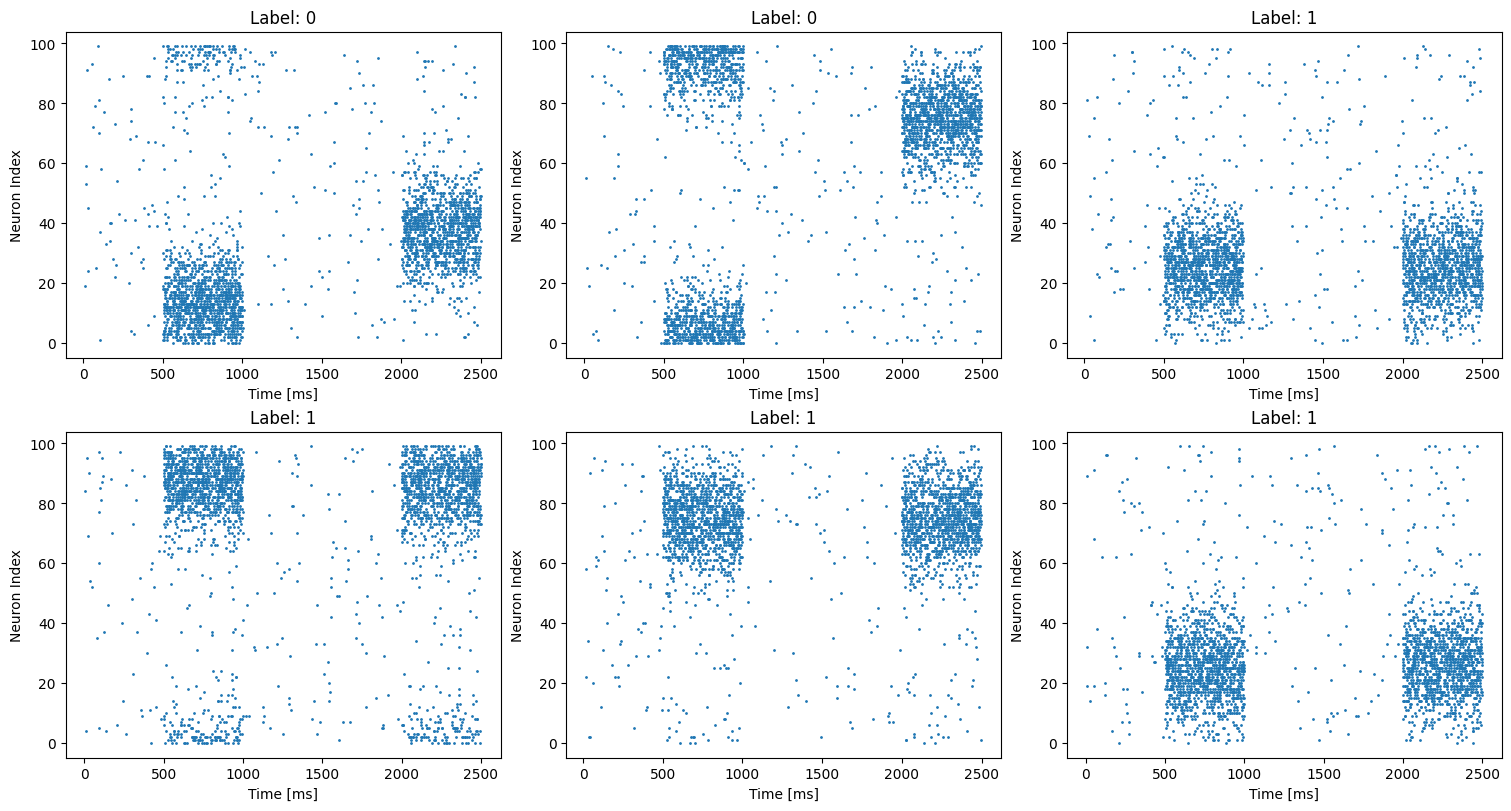

In [17]:
with bst.environ.context(dt=1. * u.ms):
    xs, ys = next(iter(DMSDataset()))

fig, gs = braintools.visualize.get_figure(2, 3, 4., 5.)
for i in range(6):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    t_indices, n_indices = np.where(xs[i] > 0)
    ax.scatter(t_indices, n_indices, s=1)
    ax.set_title(f'Label: {ys[i]}')
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Neuron Index')

### 3.3 Training with Online Learning Algorithm
We will now employ the previously defined spiking neural network model to address the Delayed Matching-to-Sample task using online learning methods. We will utilize online learning algorithms to continuously update the network weights, thereby enhancing network performance.

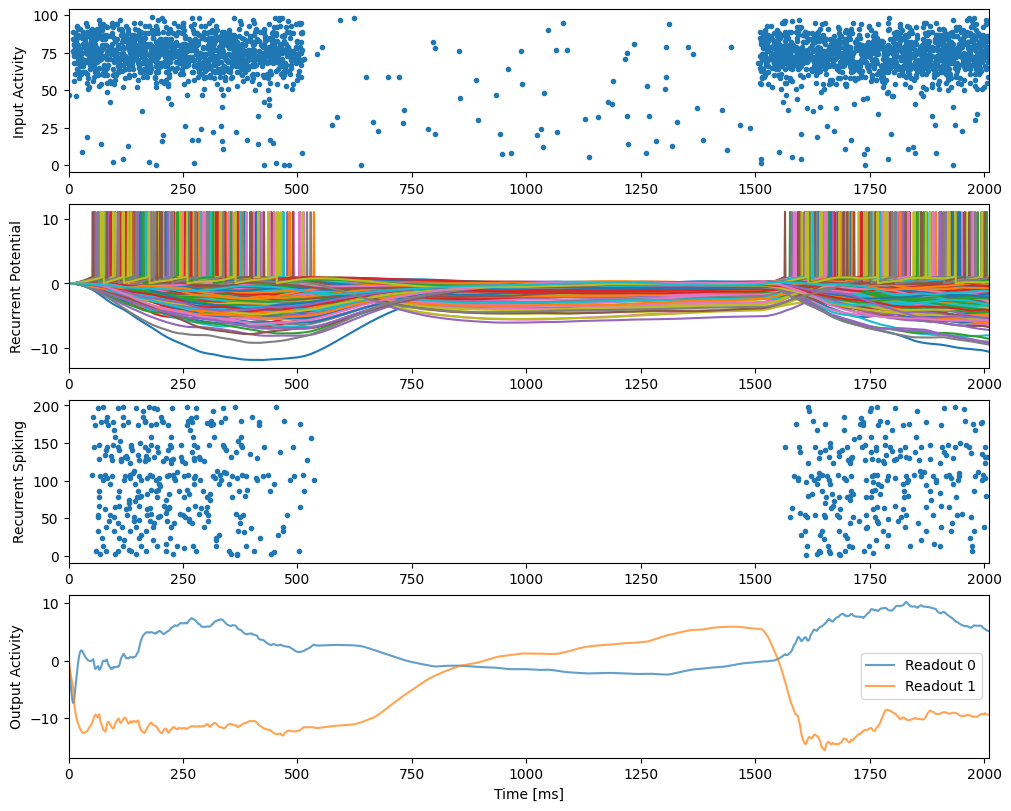

loss = 0.59819, acc=0.81250: : 100it [01:53,  1.13s/it]


Epoch 1, acc=0.73719, loss=0.94980


loss = 0.47631, acc=0.92188: : 100it [02:26,  1.46s/it]


Epoch 2, acc=0.80070, loss=0.58977


loss = 0.50963, acc=0.82812: : 100it [02:03,  1.24s/it]


Epoch 3, acc=0.86352, loss=0.50455


loss = 0.39561, acc=0.92969: : 100it [02:00,  1.21s/it]

Epoch 4, acc=0.90234, loss=0.44642


In [18]:
with bst.environ.context(dt=1. * u.ms):
    data = DMSDataset(
        bg_fr=1. * u.Hz,
        t_fixation=10. * u.ms,
        t_sample=500. * u.ms,
        t_delay=1000. * u.ms,
        t_test=500. * u.ms,
        n_input=100,
        firing_rate=100. * u.Hz,
        batch_size=128,
        num_batch=100,
    )
    net = GifNet(
        n_in=data.num_inputs,
        n_rec=200,
        n_out=data.num_outputs,
        tau_neu=100. * u.ms,
        tau_syn=100. * u.ms,
        tau_I2=1500. * u.ms,
        A2=1. * u.mA,
    )
    net.verify(next(iter(data))[0], num_show=1)

    onliner = OnlineTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        n_sim=data.n_sim,
        x_fun=lambda x_local: np.transpose(x_local, (1, 0, 2))
    )

    losses, accs = onliner.f_train()

Here are the training results from the online learning:

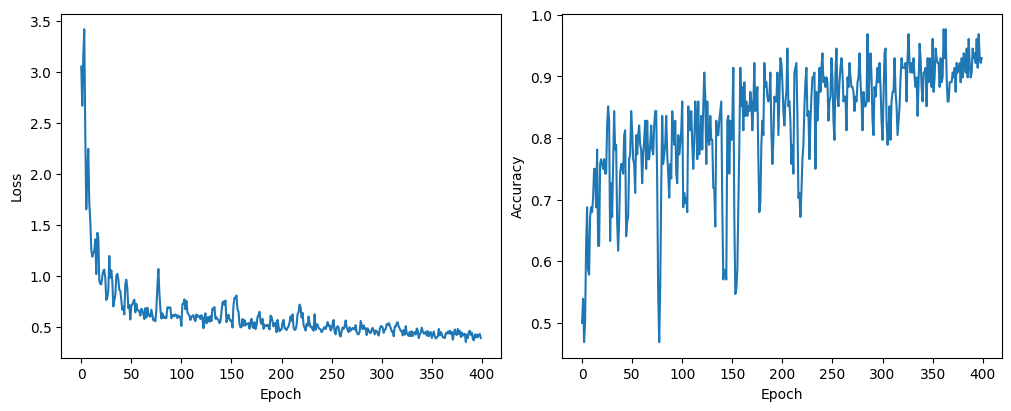

In [19]:
fig, gs = braintools.visualize.get_figure(1, 2, 4., 5.)
fig.add_subplot(gs[0, 0])
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
fig.add_subplot(gs[0, 1])
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

We can visualise a sample's network activity:

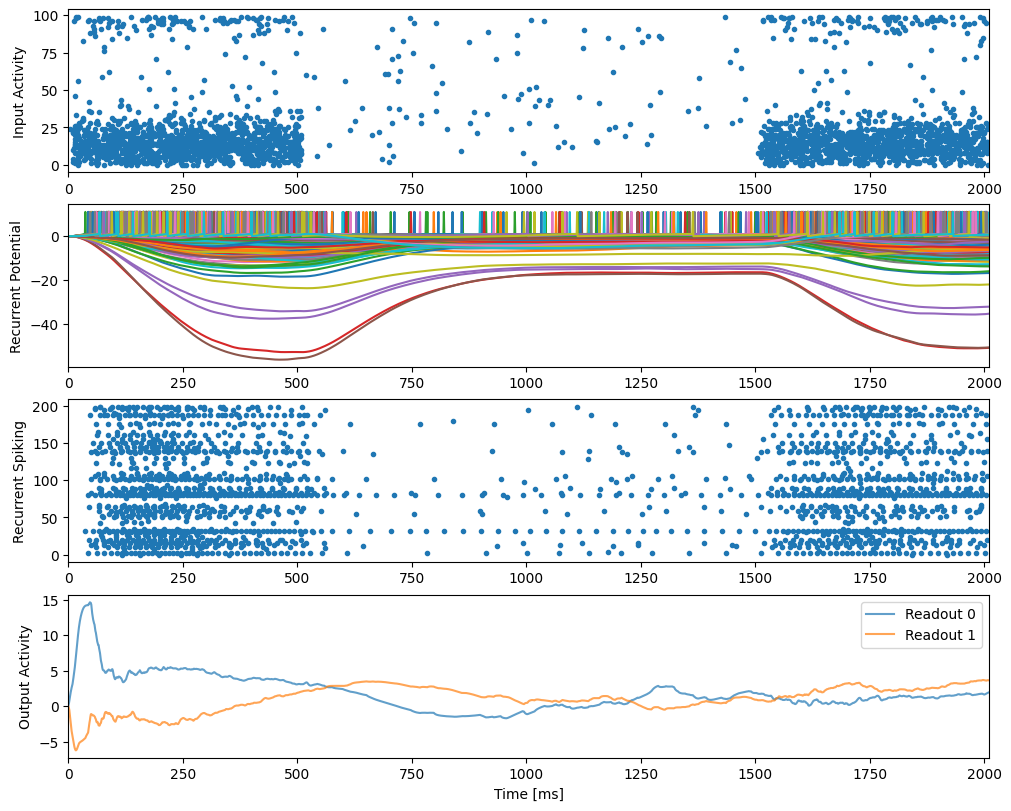

In [20]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

### 3.4 Training with BPTT Algorithm
We can readily compare the performance between online learning and BPTT offline learning approaches. Now, we will employ the BPTT offline learning algorithm to train this network.

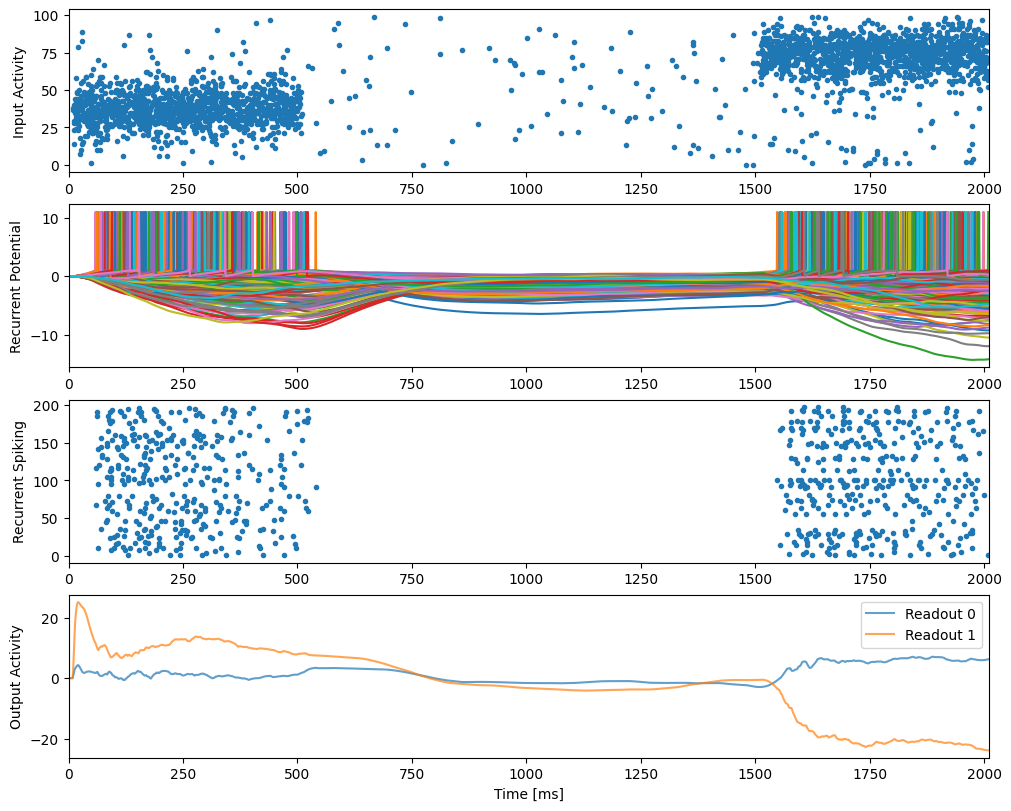

loss = 5.31876, acc=0.55469: : 18it [01:11,  3.95s/it]


KeyboardInterrupt: 

In [21]:
with bst.environ.context(dt=1. * u.ms):
    data = DMSDataset(
        bg_fr=1. * u.Hz,
        t_fixation=10. * u.ms,
        t_sample=500. * u.ms,
        t_delay=1000. * u.ms,
        t_test=500. * u.ms,
        n_input=100,
        firing_rate=100. * u.Hz,
        batch_size=128,
        num_batch=100,
    )
    net = GifNet(
        n_in=data.num_inputs,
        n_rec=200,
        n_out=data.num_outputs,
        tau_neu=100. * u.ms,
        tau_syn=100. * u.ms,
        tau_I2=1500. * u.ms,
        A2=1. * u.mA,
    )
    net.verify(next(iter(data))[0], num_show=1)

    offliner = BPTTTrainer(
        target=net,
        opt=bst.optim.Adam(lr=1e-3),
        dataset=data,
        n_sim=data.n_sim,
        x_fun=lambda x_local: np.transpose(x_local, (1, 0, 2))
    )

    losses, accs = offliner.f_train()

Unfortunately, we did not see BPTT offline learning converge effectively on this task.

We can visualise the network activity of a sample:

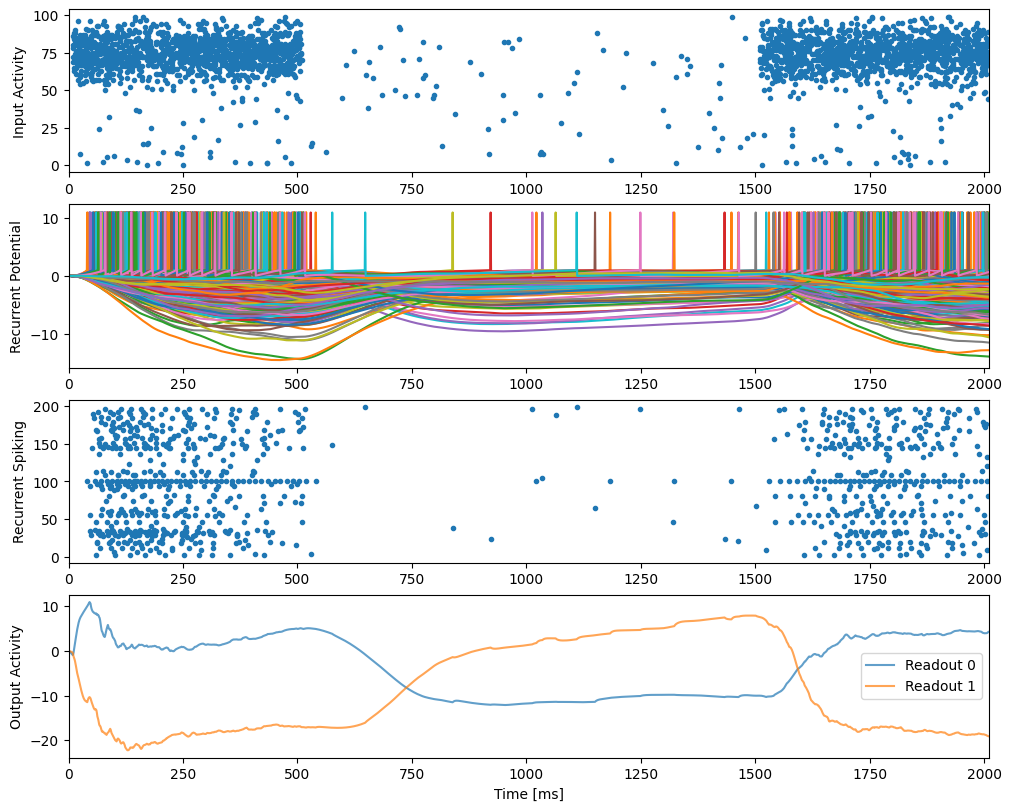

In [22]:
with bst.environ.context(dt=1. * u.ms):
    net.verify(next(iter(data))[0], num_show=1)

## 4. Conclusion

This document provides an in-depth exploration of utilizing `brainscale` for online learning mechanisms in Spiking Neural Networks (SNNs), encompassing two primary aspects:

1. Theoretical Foundations
    - Introduction to three core components of SNNs: neuronal dynamics, synaptic dynamics, and network dynamics
    - Introduction to the Leaky Integrate-and-Fire (LIF) neuron model and the Generalized Integrate-and-Fire (GIF) neuron model

2. Practical Applications
    - Demonstration of training brain-inspired computing models for image classification tasks using the Neuromorphic-MNIST (N-MNIST) dataset as a case study
    - Illustration of training brain simulation models for classical working memory tasks through the Delayed Matching-to-Sample (DMS) task
    - Comparative analysis of online learning methods versus Backpropagation Through Time (BPTT)

Through the integration of theoretical analysis and experimental validation, we hope this document serves as a valuable reference for readers seeking to understand and implement online learning solutions for SNNs using `brainscale`.